In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l



In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) 
    #生成形状与y相同的随机噪声
    #噪声服从均值为0，标准差为0.01的正态分布
    #将噪声加到y上，使数据更接近真实情况
    return X, y.reshape((-1, 1))  
    #y.reshape((-1, 1))将y重塑为列向量，-1表示自动计算该维度的大小

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], '\nlabel:', labels[0])



features: tensor([ 0.6592, -0.0866]) 
label: tensor([5.8057])


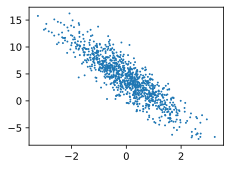

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
#第一个参数：x轴数据（特征的第二维）；
#第二个参数：y轴数据（标签）；
#第三个参数：散点的大小
d2l.plt.show()



In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #list(range(num_examples)) 创建一个从0到样本数-1的索引列表
    #random.shuffle(indices) 打乱索引列表
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        #每次从indices里面取出i到i+batch_size的元素，作为一批次
        #通过yield features[batch_indices], labels[batch_indices]返回一批次的数据

batch_size = 10
#使用for循环是因为data_iter返回的是一个生成器函数
#生成器使用yield关键字返回数据，每次调用只生成一个批次的数据，不会一次性将所有数据加载到内存中
#可以通过for循环来逐个获取生成器产生的值
for X, y in data_iter(batch_size, features, labels):
    # 每次循环：
    # 1. 调用data_iter获取下一批数据
    # 2. X获取特征批次
    # 3. y获取标签批次
    # 4. 处理这一批数据
    # 5. 继续循环直到所有数据都处理完
    print(X, '\n', y)
    break


tensor([[ 0.1513, -1.1873],
        [-1.5488,  0.6091],
        [ 2.2704, -1.3057],
        [ 0.0985,  0.2025],
        [-0.9429, -0.9351],
        [ 0.3068, -0.7719],
        [-0.1248, -1.9929],
        [-0.6235, -0.2339],
        [-0.7472, -0.7064],
        [ 0.0223, -0.6537]]) 
 tensor([[ 8.5227],
        [-0.9791],
        [13.1920],
        [ 3.7101],
        [ 5.4868],
        [ 7.4424],
        [10.7487],
        [ 3.7455],
        [ 5.1064],
        [ 6.4630]])


In [6]:
w = torch.normal(0, 0.01, (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b



In [7]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    #防止y和y_hat形状不同，使用reshape函数将y_hat的形状调整为与y相同

def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        #在更新参数之前，关闭梯度计算，以节省内存和提高计算效率
        for param in params: #遍历所有参数
            param -= lr * param.grad / batch_size #更新参数
            param.grad.zero_() #将参数的梯度清零，以便下一次计算梯度时不会累加


In [8]:
lr = 0.03 #学习率
num_epochs = 3 #训练轮次
net = linreg #模型
loss = squared_loss #损失函数

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): # 获取一个批次的数据
        l = loss(net(X, w, b), y) # 计算损失
        l.sum().backward() # 计算梯度，l.sum()将l中的所有元素相加，得到一个标量，pytorch的backward()函数要求输入是一个标量
        sgd([w, b], lr, batch_size) # 更新参数
    with torch.no_grad(): # 关闭梯度计算
        train_l = loss(net(features, w, b), labels) # 计算训练损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')




epoch 1, loss 0.034045
epoch 2, loss 0.000125
epoch 3, loss 0.000051


In [9]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')


w的估计误差: tensor([ 0.0005, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


In [10]:
#线性回归的简洁实现

import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [11]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) 
    #data.TensorDataset将张量组合成数据集
    #*data_arrays解包数据数组元组
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
    #data.DataLoader创建一个数据加载器，用于批量处理数据
    #batch_size指定每个批次的数据量
    #shuffle=is_train表示是否在每个epoch重新打乱数据

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))


[tensor([[ 0.1928,  0.2896],
         [ 0.5189,  0.8459],
         [-0.6849,  0.7619],
         [ 0.9294,  1.8300],
         [ 0.8586, -0.4365],
         [-1.3235,  1.7877],
         [-0.4782,  0.6321],
         [-1.2132, -0.2683],
         [ 0.0190, -1.1671],
         [-0.4584,  1.0489]]),
 tensor([[ 3.5953],
         [ 2.3734],
         [ 0.2158],
         [-0.1552],
         [ 7.3965],
         [-4.5268],
         [ 1.1115],
         [ 2.6993],
         [ 8.2055],
         [-0.2844]])]

In [12]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1)) #nn.Sequential是一个有序的容器，用于搭建神经网络层，相当于list of layers
#nn.Linear(2, 1)定义一个线性层，输入特征数为2，输出特征数为1

net[0].weight.data.normal_(0, 0.01) #初始化权重
net[0].bias.data.fill_(0) #初始化偏置

loss = nn.MSELoss() #均方损失

trainer = torch.optim.SGD(net.parameters(), lr=0.03) #随机梯度下降
#SGD的参数：net.parameters()获取模型中的所有参数；
#lr=0.03学习率



In [13]:
num_epochs = 3 #训练轮次
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) #计算损失  
        trainer.zero_grad() #梯度清零
        l.backward() #反向传播,计算梯度
        trainer.step() #更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')



epoch 1, loss 0.000276
epoch 2, loss 0.000095
epoch 3, loss 0.000095


In [14]:
def linreg(features, labels, num_epochs, batch_size, learning_rate):
    #data process
    data_iter = load_array((features, labels), batch_size)
    net = nn.Sequential(nn.Linear(len(features[0]), 1))
    net[0].weight.data.normal_(0, 0.01)
    net[0].bias.data.fill_(0)
    loss = nn.MSELoss()
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')
